In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Input, Flatten, concatenate, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from matplotlib import style
import os
import datetime
style.use('ggplot')

In [2]:
df = pd.read_csv('data/expanded_aastock_HSI_ret.csv')
df = df[df['news_content']!='Error']
df.dropna(subset=['news_content', 'stock_code','ret1'],inplace=True)
####################################################################################
df['ret'] = df['ret1']  # use yesterday's close - tmr's close returns for training
df['dir'] = df['ret'].apply(lambda x: 1 if x>0.02 else 0 if x<-0.02 else None)
####################################################################################
df = df.sort_values(by='news_date',ignore_index=True)
df['stock_code'] = df['stock_code'].apply(lambda x: x[:-3])
# train test split
train_df = df[(df['news_date']<'2019-06')]
train_df.dropna(subset=['dir'], inplace=True)
test_df = df[(df['news_date']>='2019-06')]
test_df.dropna(subset=['dir'], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# download pre-trained layer
url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
pretrain_layer = hub.KerasLayer(url, input_shape=[], dtype=tf.string, trainable=False)

In [4]:
tf.random.set_seed(123)
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  model = tf.keras.Sequential()
  model.add(pretrain_layer)

  model.add(Dense(64, activation='elu', kernel_initializer='he_normal'))
  model.add(Dropout(0.3))  
  model.add(Dense(32, activation='elu', kernel_initializer='he_normal'))
  model.add(Dropout(0.3))  
  model.add(Dense(16, activation='elu', kernel_initializer='he_normal'))
  model.add(Dropout(0.3))  
  model.add(Dense(8, activation='elu', kernel_initializer='he_normal'))
  model.add(Dropout(0.3))  

  model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               147354880 
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0

In [0]:
tf.random.set_seed(123)
train_dataset = tf.data.Dataset.from_tensor_slices(( train_df['title'], train_df['dir']))
train_dataset.cache()
train_dataset.shuffle(400000,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(32, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df['title'], test_df['dir']))
test_dataset.cache()
test_dataset.shuffle(400000)
test_dataset = test_dataset.batch(32, drop_remainder=True)

In [0]:
filepath= "model/epochs_{epoch:03d}_val_acc_{val_accuracy:.3f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [early_stop, checkpoint, tensorboard_callback]

In [0]:
#%load_ext tensorboard
#%tensorboard --port=5036 --logdir $logdir

In [8]:
tf.random.set_seed(123)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_dataset,epochs=3000, validation_data=test_dataset, shuffle=True, callbacks=callbacks_list)

Epoch 1/3000
395/395 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.5366
Epoch 00001: val_loss improved from inf to 0.68168, saving model to drive/My Drive/model/epochs_001_val_acc_0.551.hdf5
395/395 [==============================] - 66s 167ms/step - loss: 0.6984 - accuracy: 0.5366 - val_loss: 0.6817 - val_accuracy: 0.5506
Epoch 2/3000
395/395 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.5726
Epoch 00002: val_loss improved from 0.68168 to 0.66550, saving model to drive/My Drive/model/epochs_002_val_acc_0.608.hdf5
395/395 [==============================] - 59s 149ms/step - loss: 0.6808 - accuracy: 0.5726 - val_loss: 0.6655 - val_accuracy: 0.6079
Epoch 3/3000
395/395 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.5910
Epoch 00003: val_loss improved from 0.66550 to 0.65654, saving model to drive/My Drive/model/epochs_003_val_acc_0.619.hdf5
395/395 [==============================] - 60s 152ms/step - loss: 0.6736 

In [0]:
df['score'] = model.predict(df['title'])

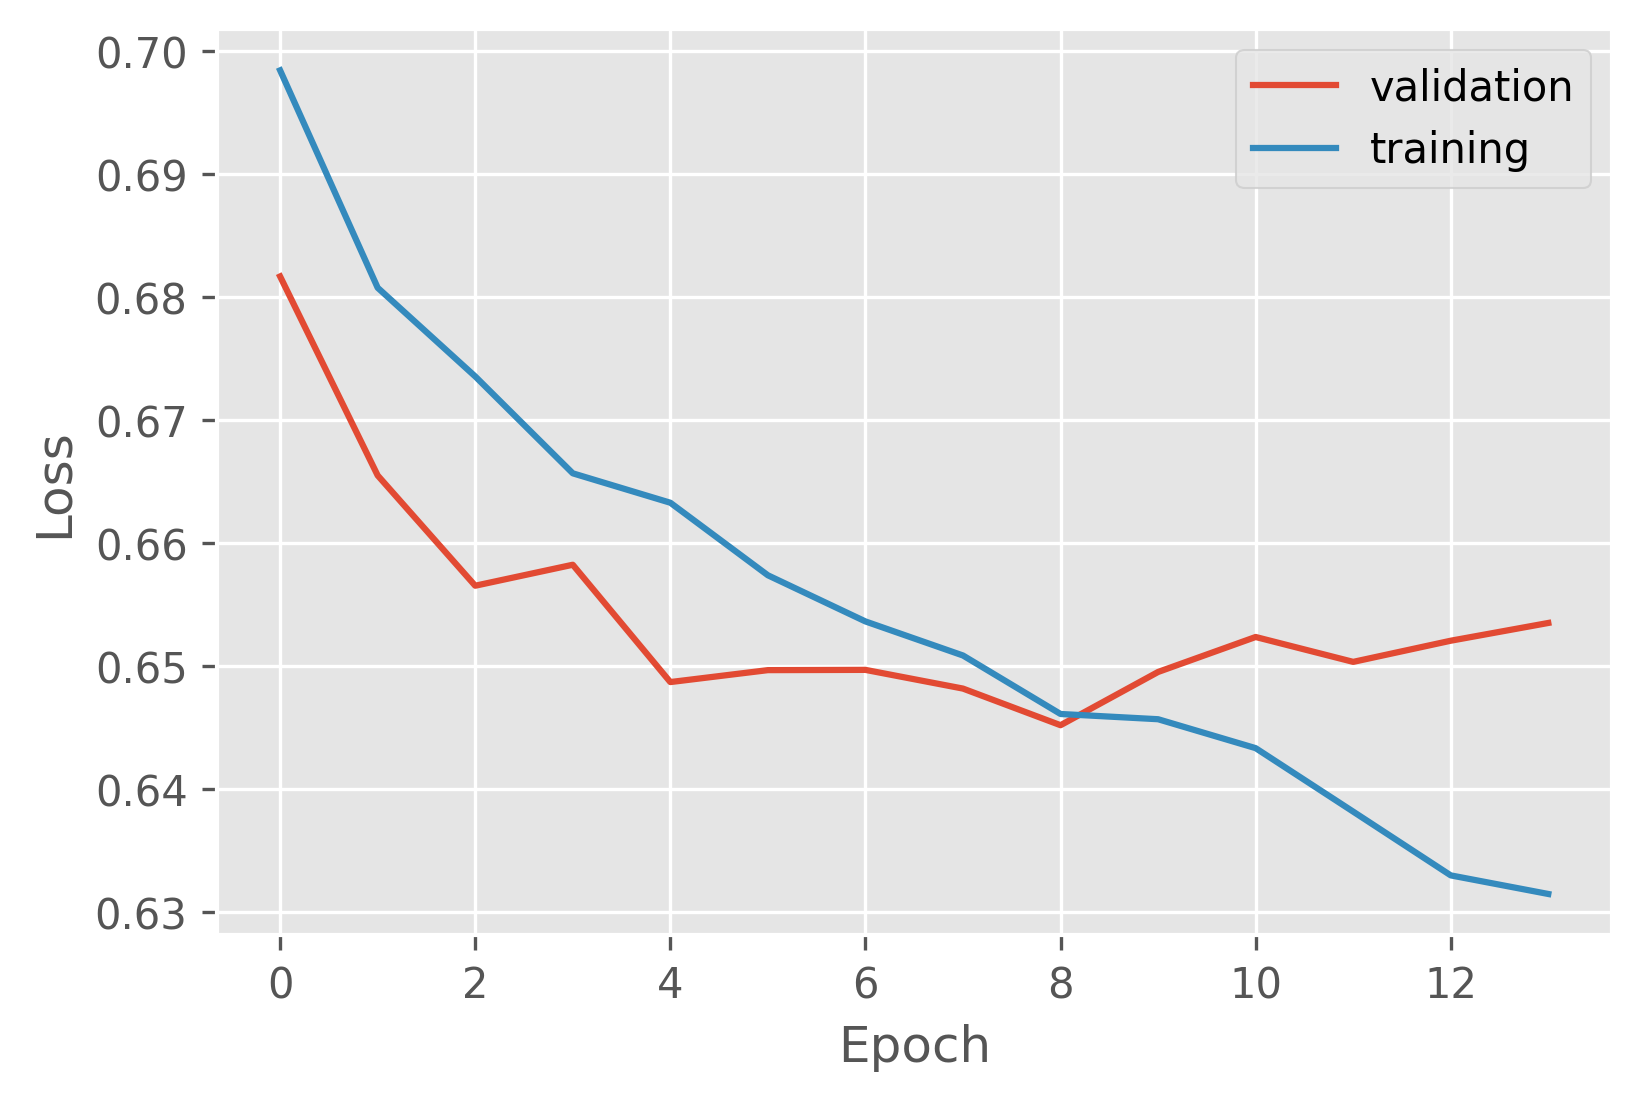

In [11]:
plt.figure(dpi=300)
plt.plot(history.history['val_loss'], label='validation')
plt.plot(history.history['loss'], label='training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("plot/training_loss.png")

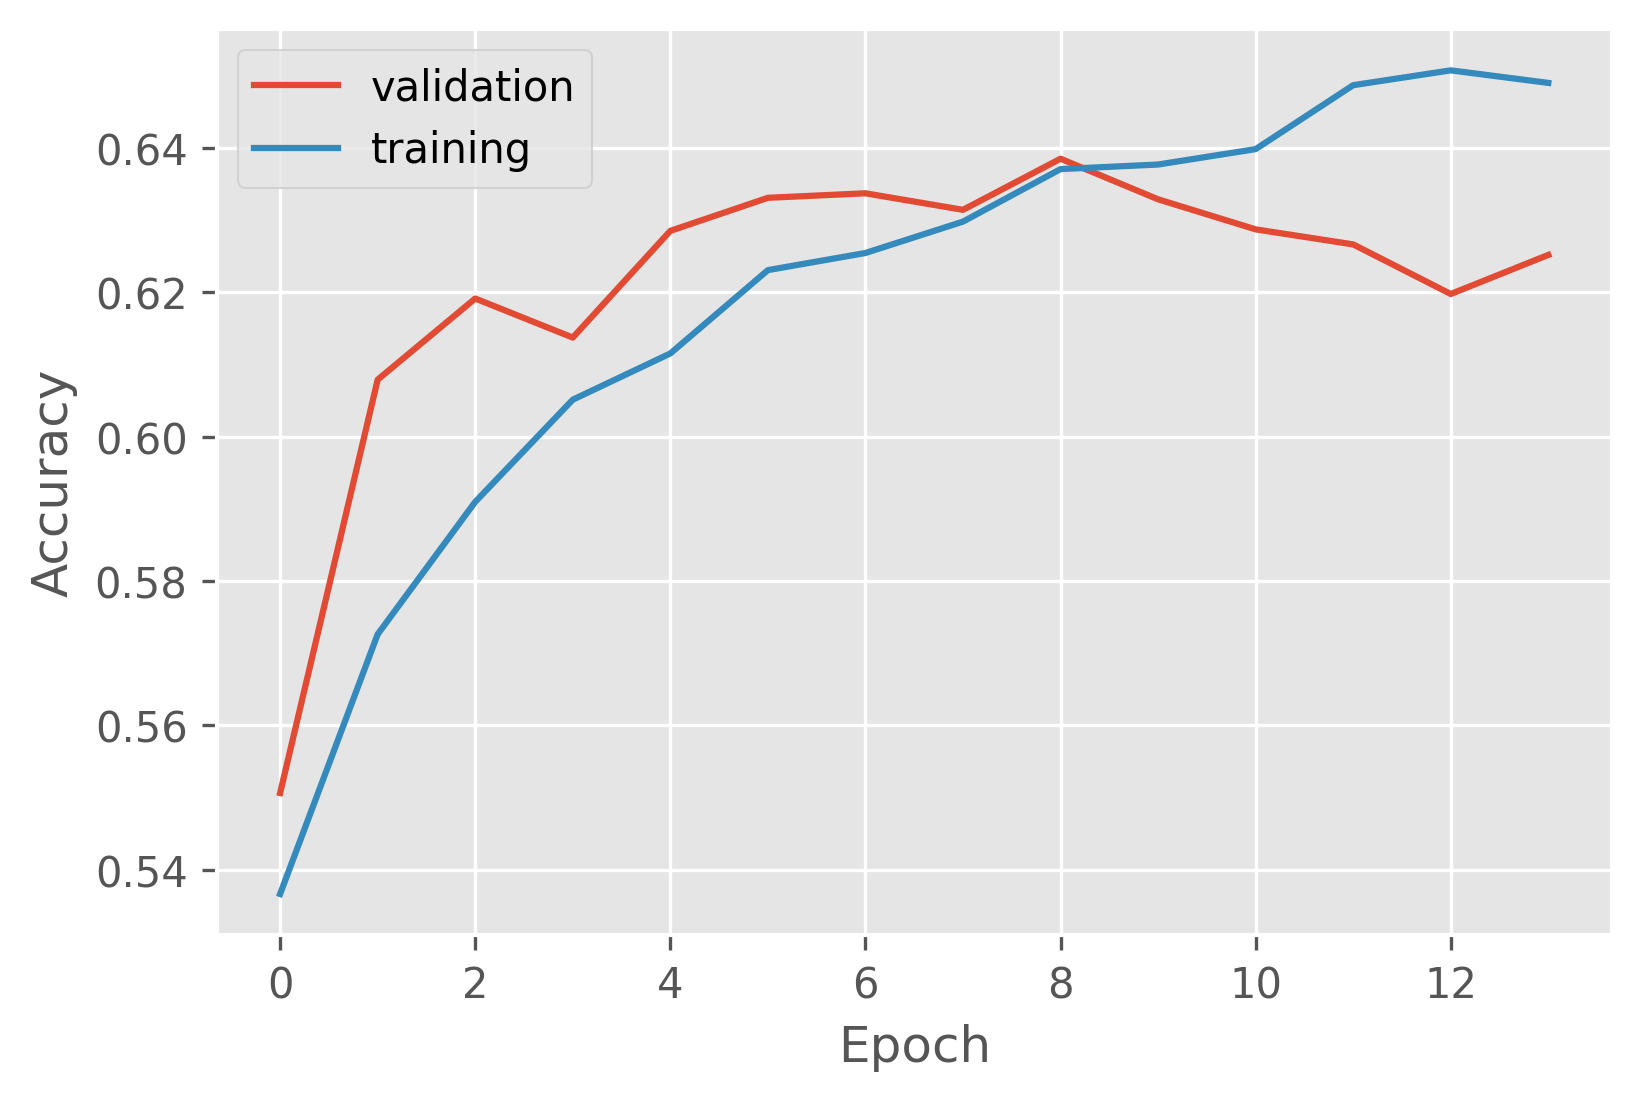

In [12]:
plt.figure(dpi=300)
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("plot/training_acc.png")

In [0]:
df.to_csv('data/aastock_HSI_trained.csv', index=False)